# Problem Set 2 

<h4> by Hoang Tran, modified from the version by Xide Xia and Kate Saenko. <br> </h4>


---

This assignment will introduce you to:
1. Understanding the power of ReLU activation.
2. Implementing your own autograd.
3. Implementing a simple MLP.
4. Basic functionality in PyTorch

This code has been tested on Colab. 

---

# Problem 1: Universal approximation power of ReLU networks

As we dicussed in class, a two layer NN with sigmoid activation function is a universal approximator, i.e: with sufficient hidden units, it can approximate any real function with desired accuracy. In this problem we want to demonstrate universal approximation power of NNs using ReLU activation units.

## **Q1.1** 
Show that, by composing only 2 hidden units in a ReLU network, i.e. $\hat{y} = \sum_{i=1}^2a_i\ max(0,b_ix+c_i)$, we can build an approximation to the step function $1[x>0]$.
The approximator should have value 1 for all values larger than $\delta$ and decreasing linearly for any value between 0 and $\delta$.

**Solution:**
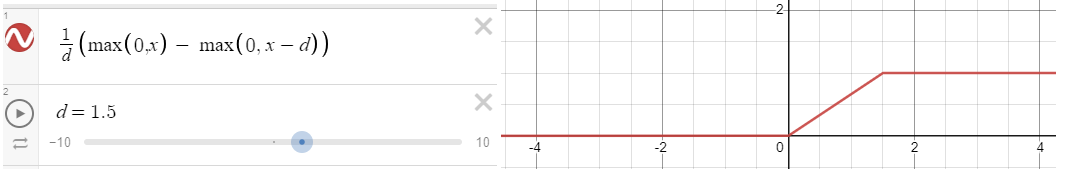

## **Q1.2** 

Show that by composing 4 hidden units in a ReLU network; we can build an approximation to the unit impulse function of duration $\delta$

\begin{equation}
u_\delta(x) = 1[0\leq x\leq \delta]
\end{equation}

The approximator should have value $1$ between $\frac{\delta}{4}$ and $\frac{3\delta}{4}$ and should be increasing/decreasing on either side of this for a duration of $\frac{\delta}{2}$, i.e., it should be 0 for all values less than $\frac{-\delta}{4}$ and more than $\frac{5\delta}{4}$

**Solution:**
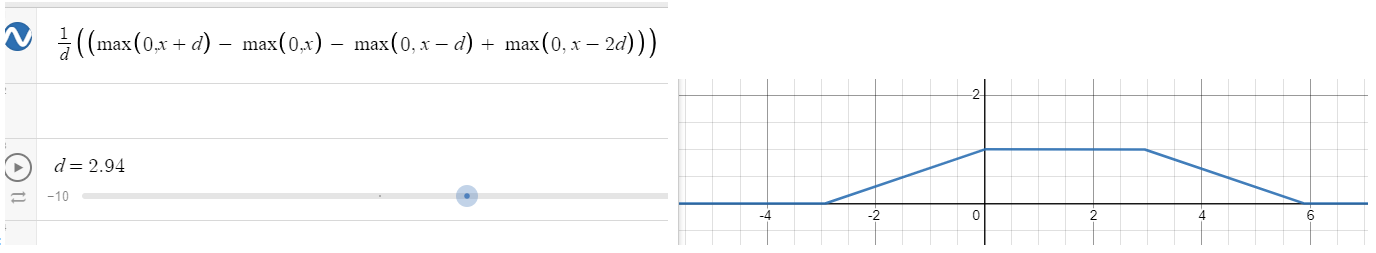


## **Q1.3** 
Using your approximator for the unit impulse function in Q1.2, complete the code given bellow to draw the approximator for different duration values $\delta$.

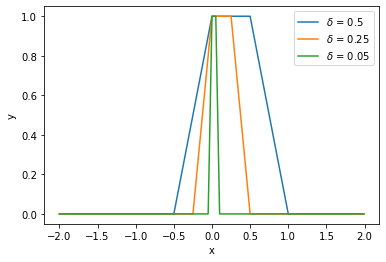

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0,x)
def hat_u_delta(x,delta):
    ## -- ! code required   
    return (1 / delta) * (relu(x + delta) - relu(x) - relu(x - delta) + relu(x - 2 *delta))

def draw_impulse(deltas):
    x = np.arange(-2, 2, 0.01).reshape((-1,1))
    for delta in deltas:
        plt.plot(x,hat_u_delta(x,delta),label='$\delta$ = '+str(delta))
    plt.legend();
    plt.xlabel('x')
    plt.ylabel('y');

draw_impulse([0.5, 0.25, 0.05])

## **Q1.4**
Imagine the idea of Riemann integral, where we approximate the integrand function with unit impulse functions -- see Figure(1) 

We will approximate the function $f(x)$ defined over $[a,b]$, using N impulse functions as follows:

$$\hat{f}(x) = \sum_{i=0}^{N-1} f(a + i \delta)\, u_\delta(x-i\delta), $$
where: $$\delta = \lfloor \frac{b-a}{N} \rfloor$$

![riemann-gif](https://drive.google.com/uc?id=1nY1BHbbEpdm7OE3USfc0BhbbEWlTmsvv)

Complete the code given below using the your implemented approximator in Q1.3 to approximate the $sin(x)$ function over $[0, 2\pi]$. The code will plot the approximation for different number of impule functions $N$.

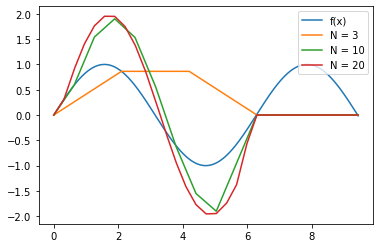

In [2]:
def f(x):
    return np.sin(x)

def hat_f(x,N,a,b):
    delta = (b-a) / N
    ## -- ! code required
    y = np.sum([f(a + i * delta) * (hat_u_delta(x - i * delta, delta)) for i in range(N - 1)], axis=0)
    return y

def draw_hat_f(N,a,b):
    x = np.arange(a, 1.5*b, 0.01).reshape((-1,1))
    plt.plot(x,f(x),label='f(x)')
    for n in N:
        y = hat_f(x,n,a,b)
        plt.plot(x,y,label='N = '+str(n));
    plt.legend(loc = 'upper right')

draw_hat_f([3,10,20],0,2*3.15)

# Problem 2: Autograd implementation.

In class, we discussed the forward and back-propagation in network layers. We pass the input through a network layer and calculate the output of the layer straightforwardly. This step is called forward-propagation. Each layer also implements a function called 'backward'. Backward is responsible for the backward pass of back-propagation. The process of back-propagation follows the schemas: Input -> Forward calls -> Loss function -> derivative -> back-propagation of errors. In neural network, any layer can forward its results to many other layers, in this case, in order to do back-propagation, we sum the deltas coming from all the target layers. 

In this problem, we will implement both forward and backward for the most commonly used layers including: linear, bias, ReLU, sigmoid, and mean square error.

In [3]:
'''backprop implementation with layer abstraction.
This could be made more complicated by keeping track of an actual DAG of
operations, but this way is not too hard to implement.
'''
import numpy as np


class Layer:
    '''A layer in a network.

    A layer is simply a function mapping inputs from R^n to R^d for some 
    specified n and d. A neural network can usually be written as a sequence of 
    layers -- eg. for input x in R^n, a 3 layer neural network might be:

    L3(L2(L1(x)))

    We can also view the loss function as itself a layer, so that the loss
    of the network is:

    Loss(L3(L2(L1(x))))

    This class is a base class used to represent different kinds of layer
    functions. We will eventually specify a neural network and its loss function
    with a list:

    [L1, L2, L3, Loss]

    where L1, L2, L3, Loss are all Layer objects.

    Each Layer object implements a function called 'forward'. forward simply
    computes the output of a layer given its input. So instead of
    Loss(L3(L2(L1(x))), we write
    Loss.forward(L3.forward(L2.forward(L1.forward(x)))).
    Doing this computation finishes the forward pass of backprop.

    Each layer also implements a function called 'backward'. Backward is
    responsible for the backward pass of backprop. After we have computed the
    forward pass, we compute
    L1.backward(L2.backward(L3.backward(Loss.backward(1))))
    We give 1 as the input to Loss.backward because backward is implementing
    the chain rule - it multiplies gradients together and so giving 1 as an
    input makes the multiplication an identity operation.

    The outputs of backward are a little subtle. Some layers may have a
    parameter that specifies the function being computed by the layer. For
    example, a Linear layer maintains a weight matrix, so that
    Linear(x) = xW
    for some matrix W.
    The input to backward should be the gradient of the final loss with respect
    to the output of the current layer. The output of backprop should be the
    gradient of the final loss with respect to the input of the current layer,
    which is just the output of the previous layer. This is why it is correct
    to chain the outputs of backprop together. However, backward should ALSO
    compute the gradient of the loss with respect to the current layer's
    parameter and store this internally to be used in training.
    '''
    def __init__(self, parameter=None, name=None):
        self.name = name
        self.forward_called = False
        self.parameter = parameter
        self.grad = None

    def zero_grad(self):
        self.grad = None

    def forward(self, input):
        '''forward pass. Should compute layer and save relevant state
        needed for backward pass.
        Args:
            input: input to this layer.
        returns output of operation.
        '''
        pass

    def backward(self, downstream_grad):
        '''Performs backward pass.

        This function should also set self.grad to be the gradient of the final
        output of the computation with respect to the parameter.

        Args:
            downstream_grad: gradient from downstream operation in the
                computation graph. This package will only consider
                computation graphs that result in scalar outputs at the final
                node (e.g. loss function computations). As a result,
                the dimension of downstream_grad should match the dimension of
                the output of this layer.

                Formally, if this operation computes F(x), and the final
                computation computes a scalar, G(F(x)), then input_grad is
                dG/dF.
        returns:
            gradient to pass to upstream layers. If the layer computes F(x, w),
            where x is the input and w is the parameter of the layer, then
            the return value should be dF(x,w)/dx * downstream_grad. Here,
            x is in R^n, F(x, w) is in R^m, dF(x, w)/dx is a matrix in R^(n x m)
            downstream_grad is in R^m and * indicates matrix multiplication.

        We should also compute the gradient with respect to the parameter w.
        Again by chain rule, this is dF(x, w)/dw * downstream_grad
        '''
        pass
        
        



Below shows an example of the full implementation of the Bias layer, including the forward and backward function. Notice self.grad stores the gradient of the loss with respect to the current layer's parameter.

In [4]:
class Bias(Layer):
    '''adds a constant bias.'''

    def __init__(self, bias, name="bias"):
        super(Bias, self).__init__(np.squeeze(bias), name)
        self.weights = np.squeeze(bias)

    def forward(self, input):
        self.input = input
        return self.parameter + self.input

    def backward(self, downstream_grad):
        self.grad = np.sum(downstream_grad, tuple(range(downstream_grad.ndim - self.parameter.ndim)))
        #self.grad = downstream_grad
        return downstream_grad


## **Q2.1** Multiplication layers.

Let's start with the basic linear and bias layer. Show the derivatives of linear and bias layer with respect to $X$ respectively.

$Z_{linear} = XW$



**Solution:**

$\frac{\partial Z}{\partial X} = W$
$\frac{\partial Z}{\partial W} = X$

Complete the forward and backward function of the linear layer. In backward, you should ALSO set the self.grad to be the gradient of the loss with respect to the current layer's parameter.

In [5]:
class Linear(Layer):
    '''Linear layer. Parameter is NxM matrix W, input is matrix x of size B x N
    where B is batch size, output is xW.'''

    def __init__(self, weights, name="Linear"):
        super(Linear, self).__init__(weights, name)
        self.weights = weights

    def forward(self, input):
        ## -- ! code required
        self.input = input
        return np.dot(self.input, self.parameter)
    
    def backward(self, downstream_grad):
        '''downstream_grad should be NxB.'''
        if len(downstream_grad.shape) != 2:
            downstream_grad = np.reshape(
                downstream_grad, (len(downstream_grad), 1))
        ## -- ! code required 
        self.grad = np.dot(self.input.T, downstream_grad)
        #self.grad = downstream_grad

        return np.dot(downstream_grad, self.parameter.T)



## **Q2.2** Activation layers.

Now let's look at the activation layers. Show the derivatives of ReLU and sigmoid. 
<p>
$ReLU(x) = max(0,x)$
</p> 
<p>
$\sigma(x)=\frac{1}{1+e^{-x}}$
</p> 

Hint: Let's assume the gradient of ReLU is 0 when x is 0.

**Solution:**

$\frac{d}{dx}ReLU(x) =   \begin{cases}
    0 &\text{if x <= 0}\\\
    1 &\text{if x > 1} 
  \end{cases}$
  
 $\sigma'(x) = \sigma(x)*(1-\sigma(x))$


Complete the forward and backward functions. There is no need to update self.grad since there is no parameter in activation layers. 

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class ReLU(Layer):
    '''ReLU layer. No parameters.'''

    def __init__(self, name="ReLU"):
        super(ReLU, self).__init__(name=name)

    def forward(self, input):
        ## -- ! code required  
        self.input = input
        return np.maximum(0, input)

    def backward(self, downstream_grad):
        ## -- ! code required  
        return np.multiply(downstream_grad, (self.input > 0))
        


class Sigmoid(Layer):
    '''Sigmoid layer. No parameters.'''

    def __init__(self, name="Sigmoid"):
        super(Sigmoid, self).__init__(name=name)

    def forward(self, input):
        ## -- ! code required  
        self.input = input
        return sigmoid(input)

    def backward(self, downstream_grad):
        ## -- ! code required  
        sig = sigmoid(self.input)
        return np.multiply(np.multiply(sig, (1 - sig)), downstream_grad)



## **Q2.3**  Loss *layers*.
Define the mean square error as follows: 
<p>
$MSE(\hat y) = \frac{1}{2N}\sum_{i=1}^N(y_i - \hat y_i)^2$. 
</p> 
where $y$ is the label and $\hat y$ is your prediction. Show the gradient of MSE w.r.t $\hat y$.


**Solution:** 

$\frac{-1}{N}(y - \hat y)$

Complete the forward and backward functions.

In [7]:
class MeanSquaredError(Layer):
    '''cross entropy loss.'''

    def __init__(self, labels, name="Mean Squared Error"):
        super(MeanSquaredError, self).__init__(name="Mean Squared Error")
        self.labels = labels
    def forward(self, input):
        '''input is BxN, output is B'''
        ## -- ! code required  
        self.input = input
        return np.sum((self.labels - self.input) ** 2) / (2 * len(self.input))

    def backward(self, downstream_grad):
        ## -- ! code required  
        self.grad = downstream_grad
        return -(self.labels - self.input) / len(self.input)



## **Q2.4** 

Now let's build a simple model using your layers, and compare the autograd results with the numeric derivatives. If everything is implemented in the correct way, the autograd results should be very close to numeric grad.

In [8]:
# This function computes the derivative numerically using the formula (f(x+delta) - f(x))/delta with small delta. First, we would compute 
# f(x) which is the original output. Then we perturb the input by a small delta then compute f(x+delta). Finally, we calculate
# the difference and divide by delta to get the derivative.
def numerical_derivative(layers, input):
    base_output = forward_layers(layers, input)
    delta = 1e-7
    
    for layer in layers:
        if layer.parameter is None:
            continue
        size = layer.parameter.size # total number of params
        shape = layer.parameter.shape # shape of params
        base_param = np.copy(layer.parameter)
        perturb = np.zeros(size)
        grad = np.zeros(size)
         
        for i in range(size):
            perturb[i] = delta # only current i-th perturb is non-zero
            layer.parameter = base_param + np.reshape(perturb, shape) # make a small change (delta) on the i-th parameter
            perturb_output = forward_layers(layers, input) # new output after adding a small change (delta) on the i-th parameter
            grad[i] = (perturb_output - base_output) / delta # update the grad of i-th parameter
            perturb[i] = 0.0 # set it back to zero
            
        layer.parameter = base_param
        layer.grad = np.reshape(np.copy(grad), shape)

def forward_layers(layers, input):
    '''Forward pass on all the layers. Must be called before backwards pass.'''
    output = input
    for layer in layers:
        output = layer.forward(output)
    #assert output.size == 1, "only supports computations that output a scalar!"
    return output


def backward_layers(layers):
    '''runs a backward pass on all the layers.
    after this function is finished, look at layer.grad to find the
    gradient with respect to that layer's parameter.'''
    downstream_grad = np.array([1])
    for layer in reversed(layers):
        downstream_grad = layer.backward(downstream_grad)


def zero_grad(layers):
    for layer in layers:
        layer.zero_grad()

        
def test_autograd():
    h = 2
    b = 3
    input = np.random.normal(np.zeros((b, h)))
    labels = np.array([0,0,1]).reshape(3,1)
    layers = [
        Linear(np.random.normal(size=(h, 2 * h))),
        Sigmoid(),
        Bias(np.array([np.random.normal()])),
        Linear(np.random.normal(size=(2 * h, 3 * h))),
        ReLU(),
        Linear(np.random.normal(size=(3 * h, 1))),
        MeanSquaredError(labels)
    ]
    output = forward_layers(layers, input)
    backward_layers(layers)
    analytics = [np.copy(layer.grad)
                 for layer in layers if layer.grad is not None]
    zero_grad(layers)

    numerical_derivative(layers, input)
    numerics = [np.copy(layer.grad)
                for layer in layers if layer.grad is not None]  
 
    # Computing the difference between the derivative of our implemented function and the numerical derivative 
    diff = np.sum([np.linalg.norm(analytic - numeric)/np.linalg.norm(numeric)
                   for analytic, numeric in zip(analytics, numerics)])
    
    assert diff < 1e-5, "autograd differs by {} from numeric grad!".format(diff)


if __name__ == "__main__":
    test_autograd()
    print("looking good!")


looking good!


## Problem 3: Implementing a simple MLP.

In this problem we will develop a neural network with fully-connected layers, aka Multi-Layer Perceptron (MLP) using the layers from Problem 2. Below, we initialize toy data  that we will use to develop your implementation.

In [9]:
# setup
import numpy as np
import matplotlib.pyplot as plt

# Create some toy data
X = np.linspace(-1, 1, 100).reshape(-1,1)
y = 5*X + 2 + 0.5*np.random.normal() # noisy y

print ('X = ', X.shape)
print('y = ', y.shape)

X =  (100, 1)
y =  (100, 1)


We will use the following class `TwoLayerMLP` to implement our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. 

In [10]:
class TwoLayerMLP(object):
    def __init__(self, input_size, hidden_size, label_size, std=1e-1, activation='sigmoid'):
        np.random.seed(0)
        self.input_size = input_size
        self.params = {}

        ## TODO: Initialize your parameters below using input_size, hidden_size, label_size
        ## the weights of the linear layers are normally distributed with standard deviation = std
        ## and mean = 0. The bias is zero. The structure of the network is as follows:
        ## linear1 -> bias1 -> sigmoid -> linear 2 -> bias 2
        
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, label_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2']  = np.zeros(label_size)  
        ###########################################################################
        #                            END OF YOUR CODE
        ###########################################################################
        self.activation = 'sigmoid'
        # Define the model 
        self.models = [
                  Linear(self.params['W1']),
                  Bias(self.params['b1']),
                  Sigmoid(),
                  Linear(self.params['W2']),
                  Bias(self.params['b2'])
                ]    
           
    def loss(self, X, y=None, reg=0.0):
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        _, C = W2.shape
        N, D = X.shape

        ## TODO: Finish the forward pass, and compute the loss using the layers and the loss
        ## layer in problem 2
        ## -- ! code required  
        input = np.copy(X)
        for model in self.models:
            input = model.forward(input)
        
        self.lossLayer = MeanSquaredError(y)
        loss = self.lossLayer.forward(input)
            

        grads = {}
        ###########################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights
        # and biases. Store the results in the grads dictionary. For example,
        # grads['W1'] should store the gradient on W1, and be a matrix of same size
        ###########################################################################
        ## -- ! code required  
        self.backward_layers(self.lossLayer.backward(1))
        grads['W1'] = self.models[0].grad
        grads['b1'] = self.models[1].grad
        grads['W2'] = self.models[3].grad
        grads['b2'] = self.models[4].grad
        
        ###########################################################################
        #                            END OF YOUR CODE
        ###########################################################################
        return loss, grads

    def backward_layers(self, downstream_grad):
        '''runs a backward pass on all the layers.
        after this function is finished, look at layer.grad to find the
        gradient with respect to that layer's parameter.'''
        for layer in reversed(self.models):
            downstream_grad = layer.backward(downstream_grad)

    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_epochs=10,
            batch_size=1, verbose=False):

        num_train = X.shape[0]
        iterations_per_epoch = 1 
        epoch_num = 0

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        grad_magnitude_history = []
        train_acc_history = []
        val_acc_history = []

        np.random.seed(1)
        for epoch in range(num_epochs):
            # fixed permutation (within this epoch) of training data
            perm = np.random.permutation(num_train)

            # go through minibatches
            for it in range(iterations_per_epoch):
                X_batch = None
                y_batch = None

                # Create a random minibatch
                idx = perm[it*batch_size:(it+1)*batch_size]
                X_batch = X[idx, :]
                y_batch = y[idx]
                # Compute loss and gradients using the current minibatch
                loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
                #print("loss", loss)
                loss_history.append(loss)

                # do gradient descent
                for param in self.params:
                    self.params[param] -= grads[param] * learning_rate

                # record gradient magnitude (Frobenius) for W1
                grad_magnitude_history.append(np.linalg.norm(grads['W1']))

            # Decay learning rate
            learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'grad_magnitude_history': grad_magnitude_history, 
        }



### Q3.1 Forward pass

Our 2-layer MLP uses a mean squared error loss layer defined in Problem 2.

Please take a look at method `TwoLayerMLP.loss`. This function takes in the data and weight parameters, and computes the class scores (output of the forward layer), the loss ($L$), and the gradients on the parameters. 

- Use the layers designed in **Problem 2** and implement the first part of the function to compute `scores` and `loss`. Afterwards, run the following two test cases.



In [11]:
input_size = 1
hidden_size = 10
label_size = 1

net = TwoLayerMLP(input_size, hidden_size, label_size)
scores = forward_layers(net.models, X)
print ('(1) Your scores:\n')
print (np.linalg.norm(scores))
print ('\n')
correct_norm = 2.00385
# # The difference should be very small (< 1e-4)
print ('Difference between your scores and correct scores:')
print (np.sum(np.abs(np.linalg.norm(scores) -correct_norm)))
print ('\n')

loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 5

# Since we generate random data, your loss would not be the same as the correct loss.
# However, the difference should be fairly small (less than 1 or 2)
print ('(2) Your loss: %f'%(loss))
print ('Difference between your loss and correct loss:')
print (np.sum(np.abs(loss - correct_loss)))

(1) Your scores:

2.0038506582894944


Difference between your scores and correct scores:
6.582894944706652e-07


(2) Your loss: 5.001061
Difference between your loss and correct loss:
0.0010609969529440377


## **Q3.2** Backward pass
- Implement the second part to compute gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`, stored in `grads`. 

Hint: you can quickly get the gradients with respect to parameters by calling **self.backward_layers**(downstream_grad).

Now debug your backward pass using a numeric gradient check.

In [12]:
# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print (ix, grad[ix])
    it.iternext() # step to next dimension

  return grad

loss, grads = net.loss(X, y, reg=0.1)

# these should all be very small
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.1)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print ('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 4.895041e-09
b1 max relative error: 6.388677e-09
W2 max relative error: 4.331386e-11
b2 max relative error: 4.954106e-12


## **Q3.3** Train the Sigmoid network
To train the network we will use stochastic gradient descent (SGD), implemented in `TwoLayerNet.train`. Train the two-layer network and plot the ['loss_history']. We don't expect you to optimize the training process. As long as the the loss graph looks reasonable (loss is going down), you will get full credits. All the current hyperparameters are set to 1 so feel free to play around with these values. 


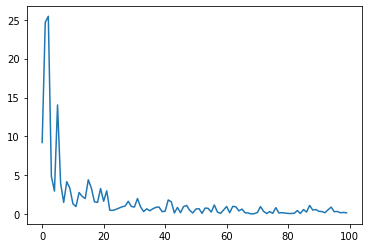

In [13]:
stats = net.train(X, y, X, y,learning_rate=.5, reg=1e-5, batch_size = 5, num_epochs=100, verbose=False)
## TODO: Plot ['loss_history'] here
## -- ! code required 
plt.plot(stats['loss_history'])
plt.show()


# Problem 4: Pytorch Intro
## **Q4.0**: Pytorch tutorials
This homework will introduce you to [PyTorch](https://pytorch.org), currently the fastest growing deep learning library, and the one we will use in this course.

Before starting the homework, please go over these introductory tutorials on the PyTorch webpage:

*   [60-minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

In [14]:
import torch

The `torch.Tensor` class is the basic building block in PyTorch and is used to hold data and parameters. The `autograd` package provides automatic differentiation for all operations on Tensors. After reading about Autograd in the tutorials above,  we will implement a few simple examples of what Autograd can do.

## **Q4.1**. Simple function
 Use `autograd` to do backpropagation on a simple function, $f=(x+y)*z$. 

**Q4.1.1** Create three inputs with values $x=-2$, $y=5$ and $z=-4$ as tensors and set `requires_grad=True` to track computation on them.



In [15]:
## -- ! code required
x = torch.tensor([-2.], requires_grad=True)
y = torch.tensor([5.], requires_grad=True)
z = torch.tensor([-4.], requires_grad=True)

x.register_hook(print)
y.register_hook(print)
z.register_hook(print)

**Q4.1.2** Compute the $q=x+y$ and $f=q \times z$ functions, creating tensors for them in the process. Print out $q,f$, then run `f.backward(retain_graph=True)`, to compute the gradients w.r.t. $x,y,z$. The `retain_graph` attribute tells autograd to keep the computation graph around after the backward pass as opposed deleting it (freeing some memory). Print the gradients. Note that the gradient for $q$ will be `None` since it is an intermediate node, even though `requires_grad` for it is automatically set to `True`. To access gradients for intermediate nodes in PyTorch you can use hooks as mentioned in [this answer](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94/2). Compute the values by hand to verify your solution.

In [16]:
## -- ! code required
q = x + y
print(q)
f = q * z
print(f)
print()
f.backward(retain_graph = True)


tensor([3.], grad_fn=<AddBackward0>)
tensor([-12.], grad_fn=<MulBackward0>)

tensor([3.])
tensor([-4.])
tensor([-4.])


**Q4.1.3** If we now run `backward()` again, it will add the gradients to their previous values. Try it by running the above cell multiple times. This is useful in some cases, but if we just wanted to re-compute the gradients again, we need to zero them first, then run `backward()`. Add this step, then try running the  backward function multiple times to make sure the answer is the same each time!

In [17]:
## -- ! code required
x.grad.zero_()
y.grad.zero_()
z.grad.zero_()
f.backward(retain_graph = True)


tensor([3.])
tensor([-4.])
tensor([-4.])


## **Q4.2** Neuron
 Implement the function corresponding to one neuron (logistic regression unit) that we saw in the lecture and compute the gradient w.r.t. $x$ and $w$. The function is $f=\sigma(w^Tx)$ where $\sigma()$ is the sigmoid function. Initialize $x=[-1, -2, 1]$ and the weights to $w=[2, -3, -3]$ where $w_3$ is the bias. Print out the gradients and double check their values by hand.

In [18]:
## -- ! code required
x = torch.tensor([-1., -2.], requires_grad = True)
w = torch.tensor([2., -3.], requires_grad = True)
b = torch.tensor([-3.], requires_grad = True)
x.register_hook(print)
w.register_hook(print)
b.register_hook(print)
f = torch.sigmoid(w.T @ x + b)
print(f)
f.backward(retain_graph = True)

tensor([0.7311], grad_fn=<SigmoidBackward0>)
tensor([0.1966])
tensor([ 0.3932, -0.5898])
tensor([-0.1966, -0.3932])


## **Q4.3**. torch.nn
 We will now implement the same neuron function $f$ with the same variable values as in Q4.2, but using the `Linear` class from `torch.nn`, followed by the [Sigmoid](https://pytorch.org/docs/stable/nn.html#torch.nn.Sigmoid) class. In general, many useful functions are already implemented for us in this package. Compute the gradients $\partial f/\partial w$ by running `backward()` and print them out (they will be stored in the Linear variable, e.g. in `.weight.grad`.) 

In [19]:
## -- ! code required
lin = torch.nn.Linear(2, 1, bias = True)
lin.weight.data = torch.tensor([[2., -3.]])
lin.bias.data = b

sig = torch.nn.Sigmoid()
print(lin(x))
f = sig(lin(x))
print(f)
f.backward()
lin.weight.grad

tensor([1.], grad_fn=<AddBackward0>)
tensor([0.7311], grad_fn=<SigmoidBackward0>)
tensor([ 0.3932, -0.5898])


tensor([[-0.1966, -0.3932]])

## **Q4.4** Module
 Now lets put these two functions (Linear and Sigmoid) together into a "module". Read the [Neural Networks tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) if you have not already.

**Q4.4.1** Make a subclass of the `Module` class, called `Neuron`. Set variables to the same values as above. You will need to define the `__init__` and `forward` methods. Our neuron would have 1 linear layer and 1 sigmoid layer.



In [20]:
import torch.nn as nn

class Neuron(nn.Module):

    def __init__(self):
        super(Neuron, self).__init__()
       ## -- ! code required
        self.layer1 = nn.Linear(2, 1, bias = True)
        self.layer1.weight.data = torch.tensor([[2., -3.]])
        self.layer1.bias.data = b
        self.layer2 = nn.Sigmoid()

    def forward(self, x):
       ## -- ! code required
        return self.layer2(self.layer1(x))

   

**Q4.4.2** Now create a  variable of your `Neuron` class called `my_neuron` and run backpropagation on it. Print out the gradients again. Make sure you zero out the gradients first, by calling `.zero_grad()` function of the parent class. Even if you will not re-compute the backprop, it is good practice to do this every time to avoid accumulating gradient!

In [21]:
## -- ! code required
my_neuron = Neuron()
f = my_neuron.forward(x)
print(f)
my_neuron.zero_grad()
f.backward(retain_graph = True)
my_neuron.layer1.weight.grad

tensor([0.7311], grad_fn=<SigmoidBackward0>)
tensor([ 0.3932, -0.5898])


tensor([[-0.1966, -0.3932]])

## **Q4.5**. Loss and SGD
 Now, lets train our neuron on some data. The code below creates a toy dataset containing a few inputs $x$ and outputs $y$ (a binary 0/1 label), as well as a function that plots the data and current solution.

w0 = 2.0 w1 = -3.0 bias = -3.0


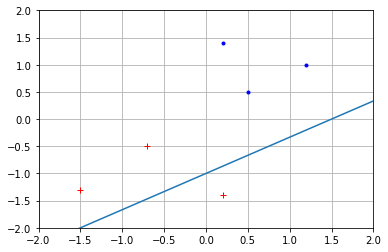

In [22]:
import matplotlib.pyplot as plt

# create some toy 2-D datapoints with binary (0/1) labels
x = torch.tensor([[1.2, 1], [0.2, 1.4], [0.5, 0.5], 
                  [-1.5, -1.3], [0.2, -1.4], [-0.7, -0.5]])
y = torch.tensor([0, 0, 0, 1, 1, 1 ])

def plot_soln(x, y, params):
  plt.plot(x[y==1,0], x[y==1,1], 'r+')
  plt.plot(x[y==0,0], x[y==0,1], 'b.')
  plt.grid(True)
  plt.axis([-2, 2, -2, 2])
  
  # NOTE : This may depend on how you implement Neuron.
  #   Change accordingly
  w0 = params[0][0][0].item()
  w1 = params[0][0][1].item()
  bias = params[1][0].item()
  
  print("w0 =", w0, "w1 =", w1, "bias =", bias)
  dbx = torch.tensor([-2, 2])
  dby = -(1/w1)*(w0*dbx + bias)  # plot the line corresponding to the weights and bias
  plt.plot(dbx, dby)

params = list(my_neuron.parameters())
plot_soln(x, y, params)

**Q4.5.1** Declare an object `criterion` of type `nn.CrossEntropyLoss`. Note that this can be called as a function on two tensors, one representing the network outputs and the other, the targets that the network is being trained to predict, to return the loss. Print the value of the loss on the dataset using the initial weights and bias defined above in Q4.2.

In [23]:
## -- ! code required
criterion = nn.CrossEntropyLoss()
preds = my_neuron.forward(x)
preds = torch.cat([preds, 1 - preds], dim = 1)
loss = criterion(preds, y)
loss

tensor(0.9426, grad_fn=<NllLossBackward0>)

**Q4.5.2** Print out the chain of `grad_fn` functions backwards starting from `loss.grad_fn`  to demonstrate what backpropagation will be run on.

In [24]:
## -- ! code required
grad = loss.grad_fn
print(grad)
while grad.next_functions != ():
    grad = grad.next_functions[0][0]
    print(grad)


**Q4.5.3** Run the Stochastic Gradient Descent (SGD) optimizer from the `torch.optim` package to train your classifier on the toy dataset. Use the entire dataset in each batch. Use a learning rate of $0.01$ (no other hyperparameters). You will need to write a training loop that uses the `.step()` function of the optimizer. Plot the solution and print the loss after 1000 iterations.

loss = 0.870725691318512
w0 = 2.161842107772827 w1 = -2.233754873275757 bias = -3.3213229179382324


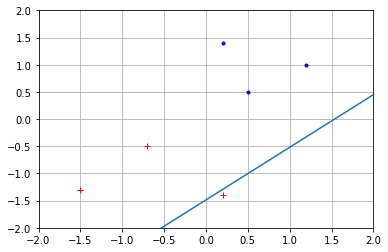

In [25]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(my_neuron.parameters(), lr=0.01)

# training loop
for i in range(1000):
    ## -- ! code required
    optimizer.zero_grad()
    preds = my_neuron.forward(x)
    preds = torch.cat([preds, 1 - preds], dim = 1)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    
print("loss =", loss.item())
params = list(my_neuron.parameters())
plot_soln(x, y, params)

**Q4.5.4** How many thousands of iterations does it take (approximately) until the neuron learns to classify the data correctly?


w0 = 2.3526384830474854 w1 = -1.4931247234344482 bias = -3.4540677070617676
w0 = 2.797351598739624 w1 = -0.7433826923370361 bias = -3.169914960861206
w0 = 3.3570139408111572 w1 = 0.15012703835964203 bias = -2.5044689178466797
w0 = 3.6997811794281006 w1 = 1.0904462337493896 bias = -1.7387933731079102
w0 = 3.8711657524108887 w1 = 1.6203970909118652 bias = -1.3298025131225586
w0 = 3.9706532955169678 w1 = 1.9202051162719727 bias = -1.118500828742981


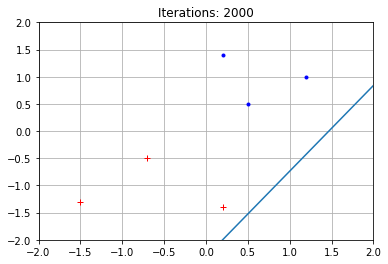

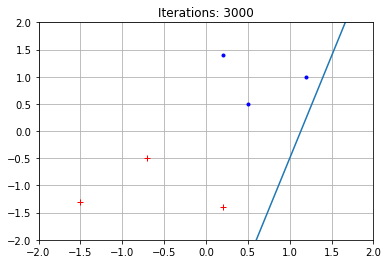

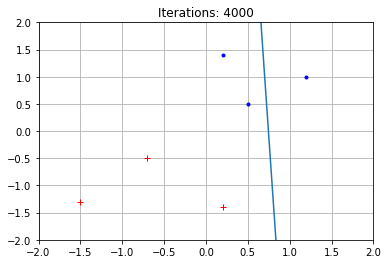

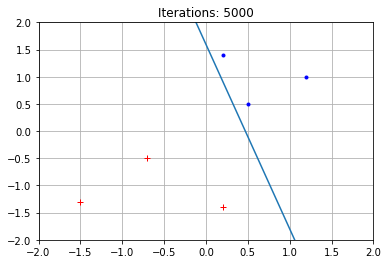

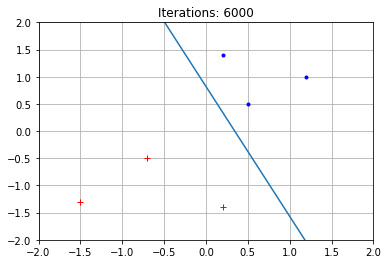

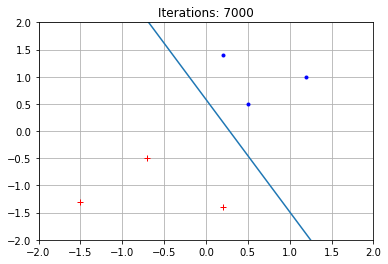

In [26]:
for i in range(6):
    for _ in range(1000):
        ## -- ! code required
        optimizer.zero_grad()
        preds = my_neuron.forward(x)
        preds = torch.cat([preds, 1 - preds], dim = 1)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        
    plt.figure()
    plt.title("Iterations: " +  str((i + 2) * 1000))
    params = list(my_neuron.parameters())
    plot_soln(x, y, params)

***Solution***
Takes approximately 5000 iterations


## **Q4.6**. Hidden space ablation

Now let's look at the size of network's hidden space. We will create and train a **2-layer MLP** network on the [SVHN Dataset](http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of photos of house numbers, collected automatically using Google's Street View. Recognizing multi-digit numbers in photographs captured at street level is an important component of modern-day map making. Google’s Street View imagery contains hundreds of millions of geo-located 360 degree panoramic images. The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents. Below are example images from the dataset. Note that for this dataset, each image (32x32 pixels) has been cropped around a single number in its center, which is the number we want to classify.

![SVHN images](http://ufldl.stanford.edu/housenumbers/32x32eg.png)

In this problem, we turn the input images into grayscale and then flat them into 1-D vector. First, download the SVHN dataset using `torchvision` and display the images in the first batch. Take a look at the [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) tutorial for an example. Follow the settings used there, such as the normalization, batch size of 4 for the `torch.utils.data.DataLoader`, etc.


Using downloaded and verified file: ./data\train_32x32.mat
    4     8     2     1


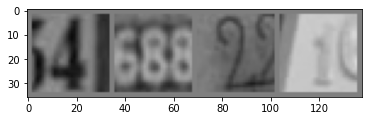

In [27]:
# solution here
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Q4.6.1 2-layer MLP 

Next, we will train a 2-layer MLP on the data. We have defined a simple 2-layer MLP for you with two fc layers and ReLU activation.



In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Neuron(nn.Module):
    def __init__(self, hidden_size):
        super(Neuron, self).__init__()
        self.l1 = nn.Linear(1024, hidden_size)
        self.l2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = x.view(-1, 1024)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

You can check the number of parameters in the model by printing out the model summary.

In [29]:
def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")       

my_neuron = Neuron(10)
model_summary(my_neuron)

model_summary

Layer_name							Number of Parameters
										

Linear(in_features=1024, out_features=10, bias=True)			10240

Linear(in_features=10, out_features=10, bias=True)			10
Total Params:10250


Instantiate the cross-entropy loss `criterion`, and an SGD optimizer from the `torch.optim` package with learning rate $.001$ and momentum $.9$. You may also want to enable GPU training using `torch.device()`.

In [30]:
import torch.optim as optim

## -- ! code required
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_neuron.parameters(), lr=0.001, momentum = .9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if we set the hardware to GPU in the Notebook settings, this should print a CUDA device:
print(device)

my_neuron.to(device)


cpu


Neuron(
  (l1): Linear(in_features=1024, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=10, bias=True)
)

### Q4.6.2 Training
Complete the training loop that makes five full passes through the dataset (five epochs) using SGD. Your batch size should be 4 and hidden size is 10. 


In [31]:
# num of epoch
stats = []
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        ## -- ! code required  
        optimizer.zero_grad()   # zero the gradient buffers
        outputs = my_neuron(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            stats.append(running_loss / 2000)
            running_loss = 0.0


[1,  2000] loss: 2.164
[1,  4000] loss: 1.877
[1,  6000] loss: 1.654
[1,  8000] loss: 1.532
[1, 10000] loss: 1.436
[1, 12000] loss: 1.396
[1, 14000] loss: 1.365
[1, 16000] loss: 1.365
[1, 18000] loss: 1.317
[2,  2000] loss: 1.335
[2,  4000] loss: 1.292
[2,  6000] loss: 1.293
[2,  8000] loss: 1.290
[2, 10000] loss: 1.301
[2, 12000] loss: 1.278
[2, 14000] loss: 1.285
[2, 16000] loss: 1.264
[2, 18000] loss: 1.283
[3,  2000] loss: 1.257
[3,  4000] loss: 1.230
[3,  6000] loss: 1.248
[3,  8000] loss: 1.245
[3, 10000] loss: 1.294
[3, 12000] loss: 1.253
[3, 14000] loss: 1.236
[3, 16000] loss: 1.268
[3, 18000] loss: 1.258
[4,  2000] loss: 1.270
[4,  4000] loss: 1.236
[4,  6000] loss: 1.220
[4,  8000] loss: 1.234
[4, 10000] loss: 1.227
[4, 12000] loss: 1.233
[4, 14000] loss: 1.242
[4, 16000] loss: 1.248
[4, 18000] loss: 1.226
[5,  2000] loss: 1.236
[5,  4000] loss: 1.216
[5,  6000] loss: 1.237
[5,  8000] loss: 1.216
[5, 10000] loss: 1.219
[5, 12000] loss: 1.218
[5, 14000] loss: 1.215
[5, 16000] 

Train the model again but this time set the hidden size as 100. 


In [32]:
my_neuron_large = Neuron(100)

# create your optimizer
optimizer = optim.SGD(my_neuron_large.parameters(), lr=0.001, momentum = .9)

# num of epoch
stats_v2 = []
for epoch in range(5):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()   # zero the gradient buffers
    outputs = my_neuron_large(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        stats_v2.append(running_loss / 2000)
        running_loss = 0.0


[1,  2000] loss: 2.139
[1,  4000] loss: 1.676
[1,  6000] loss: 1.375
[1,  8000] loss: 1.218
[1, 10000] loss: 1.145
[1, 12000] loss: 1.065
[1, 14000] loss: 1.031
[1, 16000] loss: 1.020
[1, 18000] loss: 0.967
[2,  2000] loss: 0.924
[2,  4000] loss: 0.897
[2,  6000] loss: 0.916
[2,  8000] loss: 0.878
[2, 10000] loss: 0.861
[2, 12000] loss: 0.875
[2, 14000] loss: 0.843
[2, 16000] loss: 0.814
[2, 18000] loss: 0.832
[3,  2000] loss: 0.768
[3,  4000] loss: 0.770
[3,  6000] loss: 0.777
[3,  8000] loss: 0.745
[3, 10000] loss: 0.742
[3, 12000] loss: 0.759
[3, 14000] loss: 0.765
[3, 16000] loss: 0.766
[3, 18000] loss: 0.721
[4,  2000] loss: 0.684
[4,  4000] loss: 0.683
[4,  6000] loss: 0.698
[4,  8000] loss: 0.692
[4, 10000] loss: 0.664
[4, 12000] loss: 0.707
[4, 14000] loss: 0.699
[4, 16000] loss: 0.685
[4, 18000] loss: 0.711
[5,  2000] loss: 0.637
[5,  4000] loss: 0.657
[5,  6000] loss: 0.643
[5,  8000] loss: 0.650
[5, 10000] loss: 0.647
[5, 12000] loss: 0.675
[5, 14000] loss: 0.674
[5, 16000] 

### Q4.6.3

Plot the loss of the model with hidden_size=10 with hidden_size=100 and compare the performances.

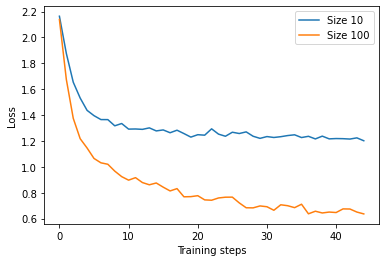

In [33]:
## -- ! code required 
plt.plot(stats, label="Size 10")
plt.plot(stats_v2, label="Size 100")
plt.ylabel("Loss")
plt.xlabel("Training steps")
plt.legend()
plt.show()

**Solution here:**

The size 100 network achieves lower loss much faster